In [1]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC
from numpyro.infer import Predictive 

import jax.numpy as np
from jax import random

import seaborn as sns

In [2]:
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

In [3]:
def model(J, sigma, y=None):
    mu  = numpyro.sample('mu', dist.Normal(0., 5.))
    tau = numpyro.sample('tau', dist.HalfCauchy(5.))
    with numpyro.plate('J', J):
        theta = numpyro.sample('theta', dist.Normal(mu, tau))
        numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)

In [4]:
rng_key = random.PRNGKey(0)

kernel = NUTS(model)
mcmc = MCMC(kernel, 500, 1000)
mcmc.run(rng_key, J, sigma, y=y, extra_fields=('potential_energy',))

sample: 100%|██████████| 1500/1500 [00:05<00:00, 264.67it/s, 7 steps of size 1.37e-01. acc. prob=0.85]


In [5]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      3.95      3.18      4.06     -1.35      9.16    261.73      1.00
       tau      3.71      3.18      2.66      0.53      7.70     56.97      1.00
  theta[0]      5.86      5.60      5.05     -3.09     14.34    301.07      1.00
  theta[1]      4.49      4.76      4.50     -2.71     12.35    410.67      1.00
  theta[2]      3.36      5.45      3.68     -5.14     11.08    419.22      1.00
  theta[3]      4.36      4.71      4.20     -3.52     11.19    471.74      1.00
  theta[4]      3.19      4.30      3.46     -3.85      9.43    400.66      1.00
  theta[5]      3.59      4.77      3.83     -3.11     12.06    341.28      1.00
  theta[6]      6.01      5.48      5.11     -1.66     15.62    184.05      1.00
  theta[7]      4.46      5.54      4.13     -4.36     12.60    240.07      1.00

Number of divergences: 18


In [6]:
pe = mcmc.get_extra_fields()['potential_energy']
print('Expected log joint density: {:.2f}'.format(np.mean(-pe)))

Expected log joint density: -53.85


In [7]:
def model2(J, sigma, y=None):
    mu  = numpyro.sample('mu', dist.Normal(0., 5.))
    tau = numpyro.sample('tau', dist.HalfCauchy(5.))
    with numpyro.plate('J', J):
        theta = numpyro.sample('theta',
                               dist.TransformedDistribution(dist.Normal(0., 1.),
                                                            dist.transforms.AffineTransform(mu, tau)))
        numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)

In [8]:
rng_key = random.PRNGKey(0)

kernel2 = NUTS(model2)
mcmc = MCMC(kernel2, 500, 1000)
mcmc.run(rng_key, J, sigma, y=y, extra_fields=('potential_energy',))

sample: 100%|██████████| 1500/1500 [00:04<00:00, 310.07it/s, 15 steps of size 2.39e-01. acc. prob=0.89]


In [9]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      4.37      3.20      4.32     -0.97      9.59   1018.31      1.00
       tau      3.50      3.11      2.70      0.01      7.76    981.61      1.00
  theta[0]      5.93      5.46      5.34     -2.60     14.60   1300.42      1.00
  theta[1]      4.91      4.79      4.81     -2.66     12.38   1295.10      1.00
  theta[2]      3.78      5.19      4.09     -4.05     12.36   1086.20      1.00
  theta[3]      4.82      4.59      4.79     -3.19     11.39   1157.39      1.00
  theta[4]      3.51      4.61      3.78     -4.23     10.12   1228.93      1.00
  theta[5]      3.99      4.81      4.32     -3.63     11.56    839.72      1.00
  theta[6]      6.15      5.01      5.58     -2.01     13.58    960.29      1.00
  theta[7]      4.86      5.07      4.63     -3.78     12.75   1137.83      1.00

Number of divergences: 0


In [10]:
pe = mcmc.get_extra_fields()['potential_energy']
print('Expected log joint density: {:.2f}'.format(np.mean(-pe)))

Expected log joint density: -46.28


In [11]:
def new_school():
    mu  = numpyro.sample('mu', dist.Normal(0., 5.))
    tau = numpyro.sample('tau', dist.HalfCauchy(5.))
    return numpyro.sample('obs', dist.Normal(mu, tau))

In [12]:
predictive = Predictive(new_school, mcmc.get_samples())
sample_predictive = predictive.get_samples(random.PRNGKey(1))

In [13]:
print(np.mean(sample_predictive['obs']))

4.4976225


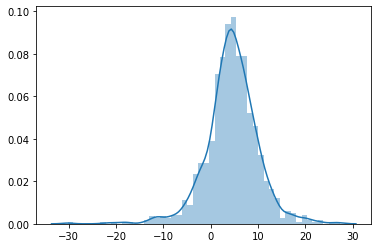

In [14]:
sns.distplot(sample_predictive['obs']);